In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.display import clear_output
clear_output()

In [ ]:
import os

import cv2
import imutils as imutils
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # machine learning
from tqdm import tqdm # make your loops show a smart progress meter 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn

RANDOM_SEED = 1
IMG_SIZE = (224, 224) # size of vgg16 input
IMG_PATH = "/content/drive/MyDrive/Happymonk/brain tumor images dataset/Brain Tumor Images Dataset"

print(os.listdir(IMG_PATH))

['test_set', 'training_set', 'validation_set']


In [ ]:
Test_Path = IMG_PATH + "/test_set/"
Training_Path = IMG_PATH + "/training_set/"
Validation_Path = IMG_PATH + "/validation_set/"

In [ ]:
def number_of_imgs(path):
    print(path)
    for value in os.listdir(path):
        print(value, "has", len(os.listdir(path + value)), "imgs")
    print('\n')
    
    
number_of_imgs(Test_Path)
number_of_imgs(Training_Path)
number_of_imgs(Validation_Path)

/content/drive/MyDrive/Happymonk/brain tumor images dataset/Brain Tumor Images Dataset/test_set/
hemmorhage_data has 10 imgs
non_hemmorhage_data has 10 imgs


/content/drive/MyDrive/Happymonk/brain tumor images dataset/Brain Tumor Images Dataset/training_set/
hemmorhage_data has 70 imgs
non_hemmorhage_data has 70 imgs


/content/drive/MyDrive/Happymonk/brain tumor images dataset/Brain Tumor Images Dataset/validation_set/
hemmorhage_data has 20 imgs
non_hemmorhage_data has 20 imgs




In [ ]:
def create_dataframe(path):
  data = []
  for value in os.listdir(path):
      for image in os.listdir(path + value + "/"):
          file_path = path + value + "/" + image
          # if hemmorhage than set if to 1 else 0
          hemmorhage = 1 if value.lower() == "hemmorhage_data" else 0
          data.append({"path": file_path, 'hemmorhage': hemmorhage})
          
  df = pd.DataFrame(data=data).sample(frac=1).reset_index(drop=True)

  return df

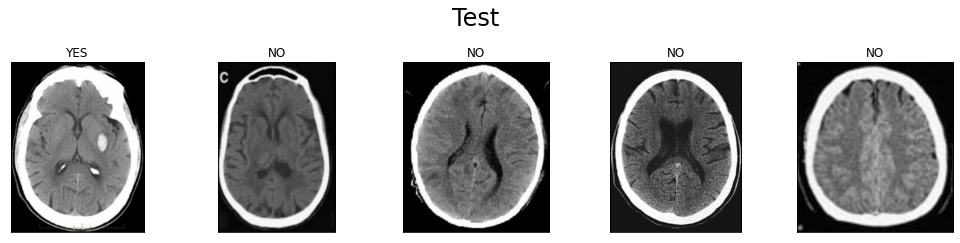

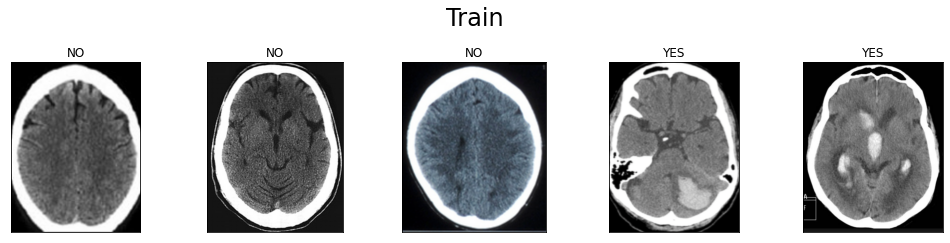

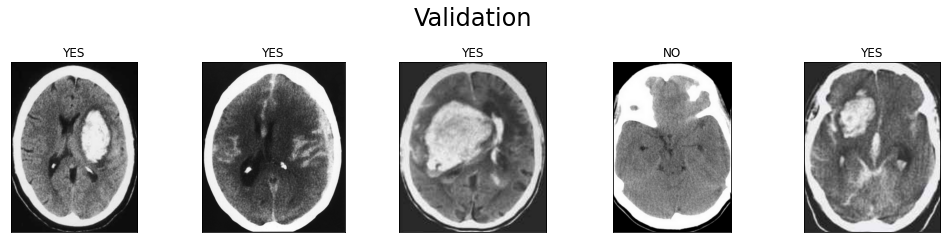

In [ ]:
%matplotlib inline
def plot_imgs(title, paths):
    fig = plt.figure(figsize=(14, 8), dpi=72)
    fig.suptitle(title, fontsize=24, y=1.05)
    for i, row in paths.iterrows():
        img=mpimg.imread(row['path'])
        plt.subplot(3, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        subtitle = 'YES' if row['hemmorhage'] == 1 else 'NO'
        plt.title(subtitle)
        plt.imshow(img)
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None)
    plt.show()
    
    
plot_imgs("Test", create_dataframe(Test_Path).sample(5).reset_index(drop=True))
plot_imgs("Train", create_dataframe(Training_Path).sample(5).reset_index(drop=True))
plot_imgs("Validation", create_dataframe(Validation_Path).sample(5).reset_index(drop=True))

In [ ]:
def crop_imgs(set_name, add_pixels_value=0):
    """Finds the extreme points on the image and crops the rectangular out of them"""
    set_new = []
    for img in set_name:
        img = cv2.imread(img)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        ext_left = tuple(c[c[:, :, 0].argmin()][0])
        ext_right = tuple(c[c[:, :, 0].argmax()][0])
        ext_top = tuple(c[c[:, :, 1].argmin()][0])
        ext_bot = tuple(c[c[:, :, 1].argmax()][0])

        add_pixels = add_pixels_value
        new_img = img[ext_top[1] - add_pixels:ext_bot[1] + add_pixels
        , ext_left[0] - add_pixels:ext_right[0] + add_pixels].copy()
        set_new.append(new_img)
        
    return np.array(set_new)

crop_imgs(create_dataframe(Test_Path)['path'])
crop_imgs(create_dataframe(Training_Path)['path'])
crop_imgs(create_dataframe(Validation_Path)['path'])

clear_output()

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.25],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    Training_Path,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    Validation_Path,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 140 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:

base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
EPOCHS = 25
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_accuracy',
#     mode='max',
#     patience=6
# )

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    
    
)

print("Training Done")
model.save("model.h5")

<ipython-input-18-ddc3bc534fae>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/25
5/5 [==============================] - 4s 794ms/step - loss: 0.8368 - accuracy: 0.9214 - val_loss: 6.2390 - val_accuracy: 0.6750
Epoch 2/25
5/5 [==============================] - 3s 638ms/step - loss: 0.7434 - accuracy: 0.9000 - val_loss: 1.8933 - val_accuracy: 0.8500
Epoch 3/25
5/5 [==============================] - 3s 635ms/step - loss: 1.4255 - accuracy: 0.8643 - val_loss: 1.6623 - val_accuracy: 0.8000
Epoch 4/25
5/5 [==============================] - 3s 637ms/step - loss: 0.8564 - accuracy: 0.9643 - val_loss: 6.1728 - val_accuracy: 0.6750
Epoch 5/25
5/5 [==============================] - 3s 760ms/step - loss: 0.9304 - accuracy: 0.9286 - val_loss: 5.3642 - val_accuracy: 0.6750
Epoch 6/25
5/5 [==============================] - 3s 613ms/step - loss: 0.4212 - accuracy: 0.9429 - val_loss: 1.7991 - val_accuracy: 0.8000
Epoch 7/25
5/5 [==============================] - 3s 639ms/step - loss: 0.9780 - accuracy: 0.9214 - val_loss: 4.3875 - val_accuracy: 0.6500
Epoch 8/25
5/5 [====

In [ ]:
# CNN
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMG_SIZE + (3,))),
    tf.keras.layers.MaxPool2D(2,2),
    #
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    #
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    ##
    tf.keras.layers.Flatten(),
    ##
    tf.keras.layers.Dense(512, activation='relu'),
    ##
    tf.keras.layers.Dense(1, activation='softmax')
])

model_cnn.compile(loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])
model_cnn_fit = model_cnn.fit( train_generator,
                      steps_per_epoch=3,
                      epochs=25,
                      validation_data=validation_generator)

Epoch 1/25
3/3 [==============================] - 3s 1s/step - loss: 292.5994 - accuracy: 0.4868 - val_loss: 64.2018 - val_accuracy: 0.5000
Epoch 2/25
3/3 [==============================] - 2s 806ms/step - loss: 30.9907 - accuracy: 0.5208 - val_loss: 24.7676 - val_accuracy: 0.5000
Epoch 3/25
3/3 [==============================] - 2s 862ms/step - loss: 8.8575 - accuracy: 0.4868 - val_loss: 17.5502 - val_accuracy: 0.5000
Epoch 4/25
3/3 [==============================] - 2s 659ms/step - loss: 8.1675 - accuracy: 0.5263 - val_loss: 8.3416 - val_accuracy: 0.5000
Epoch 5/25
3/3 [==============================] - 2s 841ms/step - loss: 3.2516 - accuracy: 0.5789 - val_loss: 8.9773 - val_accuracy: 0.5000
Epoch 6/25
3/3 [==============================] - 2s 870ms/step - loss: 3.2149 - accuracy: 0.4342 - val_loss: 6.1380 - val_accuracy: 0.5000
Epoch 7/25
3/3 [==============================] - 2s 818ms/step - loss: 2.5478 - accuracy: 0.5312 - val_loss: 6.8017 - val_accuracy: 0.5000
Epoch 8/25
3/3 [=

In [ ]:
def preprocess_imgs(path, img_size):
    set_new = []
    for value in os.listdir(path):
        for img in os.listdir(path + value):
            img = cv2.imread(path + value + "/" + img)
            img = cv2.resize(
                img,
                dsize=img_size,
                interpolation=cv2.INTER_CUBIC
            )
            set_new.append(tf.keras.applications.vgg16.preprocess_input(img))
    
    return np.array(set_new)

test_data = preprocess_imgs(Test_Path, img_size=IMG_SIZE)

reality = []
for value in os.listdir(Test_Path):
    for img in os.listdir(Test_Path + value):
        reality.append(1) if value.lower() == "hemmorhage_data" else reality.append(0)
# reality_19 = []
# for value in os.listdir(Test_Path):
#     for img in os.listdir(Test_Path + value):
#         reality_19.append(1) if value.lower() == "hemmorhage_data" else reality.append(0)
        
predictions = model.predict(test_data)
predictions_19 = model_cnn.predict(test_data)
predictions = [0 if x > 0.5 else 1 for x in predictions]
predictions_19 = [0 if x > 0.5 else 1 for x in predictions_19]
accuracy = accuracy_score(reality, predictions)
accuracy_19 = accuracy_score(reality, predictions_19)
print("Test Accuracy:", accuracy)
print("Test Accuracy_19:", accuracy_19)

1/1 [==============================] - 0s 21ms/step
Test Accuracy: 0.9
Test Accuracy_19: 0.5


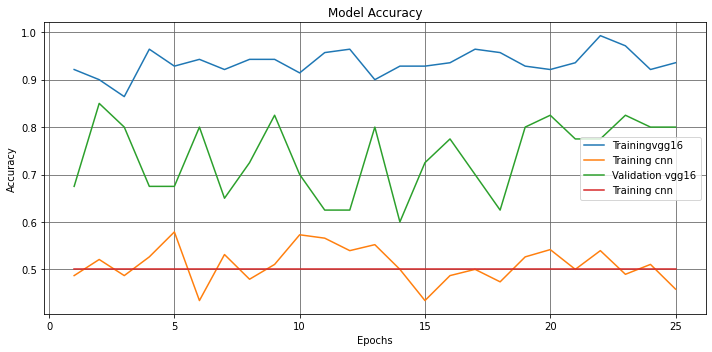

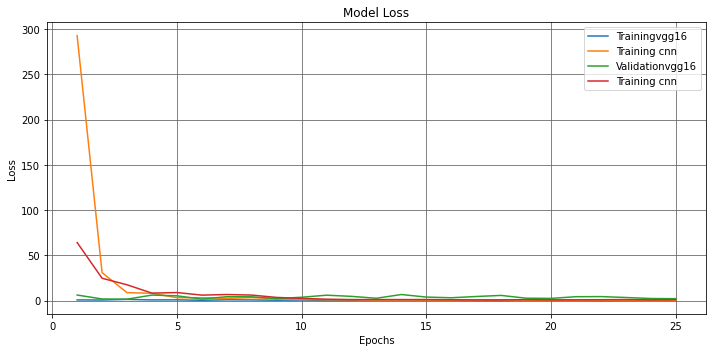

In [ ]:
acc = history.history['accuracy']
acc_cnn=model_cnn_fit.history['accuracy']

val_acc = history.history['val_accuracy']
val_acc_cnn=model_cnn_fit.history['val_accuracy']

loss = history.history['loss']
loss_cnn=model_cnn_fit.history['loss']
val_loss = history.history['val_loss']
val_loss_cnn=model_cnn_fit.history['val_loss']

epochs_range = range(1, len(history.epoch) + 1)


plt.figure(figsize=(10,5))

plt.plot(epochs_range, acc, label='Trainingvgg16')
plt.plot(epochs_range, acc_cnn, label='Training cnn')
plt.plot(epochs_range, val_acc, label='Validation vgg16')
plt.plot(epochs_range, val_acc_cnn, label='Training cnn')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))

plt.plot(epochs_range, loss, label='Trainingvgg16')
plt.plot(epochs_range, loss_cnn, label='Training cnn')
plt.plot(epochs_range, val_loss, label='Validationvgg16')
plt.plot(epochs_range, val_loss_cnn, label='Training cnn')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

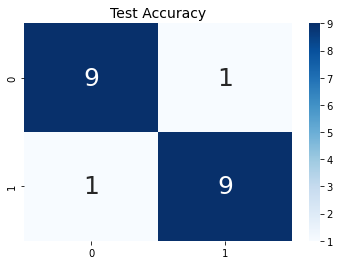

In [ ]:
confusion_mtx = confusion_matrix(reality, predictions)

ax = plt.axes()
sn.heatmap(confusion_mtx, annot=True,annot_kws={"size": 25}, cmap="Blues", ax = ax)
ax.set_title('Test Accuracy', size=14)
plt.show()

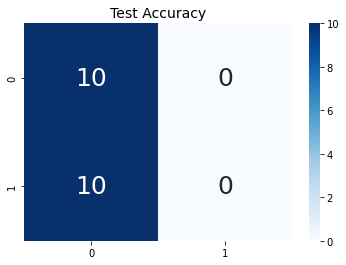

In [ ]:
confusion_mtx = confusion_matrix(reality, predictions_19)

ax = plt.axes()
sn.heatmap(confusion_mtx, annot=True,annot_kws={"size": 25}, cmap="Blues", ax = ax)
ax.set_title('Test Accuracy', size=14)
plt.show()